In [77]:
# ASL Alphabet Recognition using MediaPipe Holistic - Improved Version
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [79]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# MediaPipe Holistic setup
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [81]:
def extract_landmarks(image):
    """Extract hand landmarks using MediaPipe Holistic with improved preprocessing"""
    with mp_holistic.Holistic(static_image_mode=True, 
                             min_detection_confidence=0.5,
                             model_complexity=2) as holistic:  # Increased model complexity
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = holistic.process(image_rgb)
        
        landmarks = []
        if results.right_hand_landmarks:
            for landmark in results.right_hand_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z])
        elif results.left_hand_landmarks:  # Also check for left hand
            for landmark in results.left_hand_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z])
        else:
            landmarks = [0] * (21 * 3)
        
        return np.array(landmarks)

In [9]:
# 3. Custom Callback
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience=5):
        super(F1ScoreCallback, self).__init__()
        self.patience = patience
        self.best_f1 = 0
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        val_true = np.argmax(self.validation_data[1], axis=1)
        
        # Calculate F1 Score
        f1_scores = []
        for i in range(NUM_CLASSES):
            true_positives = np.sum((val_predict == i) & (val_true == i))
            false_positives = np.sum((val_predict == i) & (val_true != i))
            false_negatives = np.sum((val_predict != i) & (val_true == i))
            
            precision = true_positives / (true_positives + false_positives + 1e-7)
            recall = true_positives / (true_positives + false_negatives + 1e-7)
            
            f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
            f1_scores.append(f1)
        
        current_f1 = np.mean(f1_scores)
        logs['val_f1'] = current_f1
        
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print(f'\nF1 score did not improve for {self.patience} epochs. Stopping training.')


In [83]:
def load_and_preprocess_data(data_dir, target_size=(224, 224)):  # Increased image size
    """Load and preprocess the ASL dataset with augmentation"""
    X = []
    y = []
    label_map = {}
    
    for idx, label in enumerate(sorted(os.listdir(data_dir))):
        if label.startswith('.'):
            continue
        label_map[idx] = label  # Reverse mapping for evaluation
        label_dir = os.path.join(data_dir, label)
        
        print(f"Processing {label}...")
        for image_name in tqdm(os.listdir(label_dir)):
            image_path = os.path.join(label_dir, image_name)
            image = cv2.imread(image_path)
            if image is None:
                continue
            
            # Original image
            image_resized = cv2.resize(image, target_size)
            landmarks = extract_landmarks(image_resized)
            X.append(landmarks)
            y.append(idx)
            
            # Augmentation: Flip horizontally
            image_flipped = cv2.flip(image_resized, 1)
            landmarks_flipped = extract_landmarks(image_flipped)
            X.append(landmarks_flipped)
            y.append(idx)
            
            # Augmentation: Rotate slightly
            M = cv2.getRotationMatrix2D((target_size[0]/2, target_size[1]/2), 15, 1.0)
            image_rotated = cv2.warpAffine(image_resized, M, target_size)
            landmarks_rotated = extract_landmarks(image_rotated)
            X.append(landmarks_rotated)
            y.append(idx)
    
    return np.array(X), np.array(y), label_map

In [85]:
def create_improved_model(num_classes):
    """Create an improved model architecture"""
    model = Sequential([
        # Reshape input to be compatible with Conv1D
        tf.keras.layers.Reshape((21, 3), input_shape=(63,)),
        
        # Conv1D layers for feature extraction
        Conv1D(64, 3, activation='relu'),
        BatchNormalization(),
        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        
        # Additional Conv1D layer
        Conv1D(256, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        
        # LSTM layer for sequential processing
        LSTM(128, return_sequences=True),
        Dropout(0.5),
        LSTM(64),
        
        # Dense layers for classification
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [87]:
def train_model(X_train, y_train, X_val, y_val, num_classes):
    """Train the model with improved parameters"""
    model = create_improved_model(num_classes)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks = [
        ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy'),
        EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True),
        ReduceLROnPlateau(factor=0.2, patience=5, monitor='val_accuracy', min_lr=1e-6)
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,  # Increased epochs
        batch_size=32,
        callbacks=callbacks
    )
    
    return model, history

In [ ]:
# Set your data directory
DATA_DIR = "./dataset/asl_alphabet_train/asl_alphabet_train/"  # Change this to your dataset's local path

# Load and preprocess data
X, y, label_map = load_and_preprocess_data(DATA_DIR)

Processing A...


  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:30:07<00:00,  1.80s/it]


Processing B...


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:33:14<00:00,  1.86s/it]


Processing C...


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:30:28<00:00,  1.81s/it]


Processing D...


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:40:23<00:00,  2.01s/it]


Processing E...


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:35:10<00:00,  1.90s/it]


Processing F...


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:50:20<00:00,  2.21s/it]


Processing G...


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [2:09:18<00:00,  2.59s/it]


Processing H...


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [3:12:34<00:00,  3.85s/it]


Processing I...


  1%|▉                                                                             | 35/3000 [01:50<2:34:34,  3.13s/it]

In [ ]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [66]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [68]:
# Train the model
num_classes = len(label_map)
model, history = train_model(X_train, y_train, X_val, y_val, num_classes)

Epoch 1/50
1740/1740 [==============================] - 8s 4ms/step - loss: 3.3567 - accuracy: 0.0382 - val_loss: 3.3437 - val_accuracy: 0.0407 - lr: 0.0010
Epoch 2/50
   1/1740 [..............................] - ETA: 7s - loss: 3.3621 - accuracy: 0.0625

C:\Users\abhis\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1740/1740 [==============================] - 5s 3ms/step - loss: 3.3408 - accuracy: 0.0428 - val_loss: 3.3244 - val_accuracy: 0.0419 - lr: 0.0010
Epoch 3/50
1740/1740 [==============================] - 5s 3ms/step - loss: 3.3280 - accuracy: 0.0449 - val_loss: 3.3229 - val_accuracy: 0.0423 - lr: 0.0010
Epoch 4/50
1740/1740 [==============================] - 5s 3ms/step - loss: 3.3211 - accuracy: 0.0458 - val_loss: 3.3064 - val_accuracy: 0.0460 - lr: 0.0010
Epoch 5/50
1740/1740 [==============================] - 6s 3ms/step - loss: 3.3165 - accuracy: 0.0475 - val_loss: 3.3058 - val_accuracy: 0.0472 - lr: 0.0010
Epoch 6/50
1740/1740 [==============================] - 5s 3ms/step - loss: 3.3132 - accuracy: 0.0490 - val_loss: 3.2964 - val_accuracy: 0.0486 - lr: 0.0010
Epoch 7/50
1740/1740 [==============================] - 6s 3ms/step - loss: 3.3116 - accuracy: 0.0497 - val_loss: 3.2961 - val_accuracy: 0.0522 - lr: 0.0010
Epoch 8/50
1740/1740 [==============================] - 6s 3ms/step -

In [71]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

544/544 [==============================] - 2s 3ms/step - loss: 3.2841 - accuracy: 0.0591
Test accuracy: 0.0591


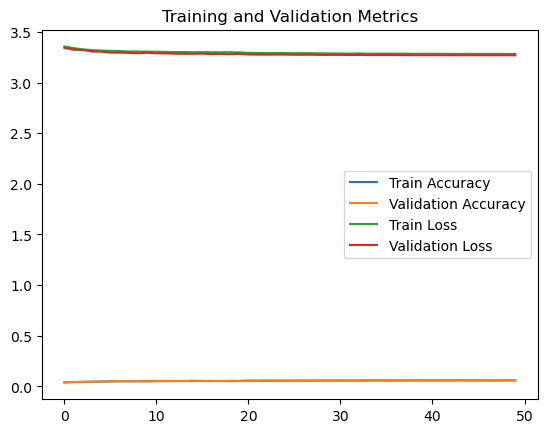

In [74]:
# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()